# Sriharsha's Notebook.

(On \#covid19 Tweet Analysis)
 
Loading in the libraries

* [1. Data and Libraries](#1)
* [2. Top 10 Tweet Sources](#2)
* [3. Top 10 Tweet Locations](#3)
* [4. Sources vs. Location](#4)
* [5. Dates](#5)
* [6. Word Cloud](#6)
* [7. Sentiment Analysis](#7)

# 1. Data & Libraries
<div id="1"></div>

In [71]:
import pandas as pd, matplotlib as mpl, matplotlib.pyplot as plt
#To show graph from matplotlib
%matplotlib inline 
import seaborn as sns, numpy as np
from wordcloud import WordCloud
import emoji
import sklearn

from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

Creating a pandas DataFrame first

In [30]:
tw = pd.read_csv('covid19_tweets.csv', encoding="utf-8")

A quick look at the data

In [31]:
tw.head() #Just checking out the data

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


In [33]:
tw.info() #Checking out data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179108 entries, 0 to 179107
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_name         179108 non-null  object
 1   user_location     142337 non-null  object
 2   user_description  168822 non-null  object
 3   user_created      179108 non-null  object
 4   user_followers    179108 non-null  int64 
 5   user_friends      179108 non-null  int64 
 6   user_favourites   179108 non-null  int64 
 7   user_verified     179108 non-null  bool  
 8   date              179108 non-null  object
 9   text              179108 non-null  object
 10  hashtags          127774 non-null  object
 11  source            179031 non-null  object
 12  is_retweet        179108 non-null  bool  
dtypes: bool(2), int64(3), object(8)
memory usage: 15.4+ MB


### Checking out null data

In [34]:
nulls = tw.isnull().sum()
nulls[nulls>0].sort_values(ascending=False)

hashtags            51334
user_location       36771
user_description    10286
source                 77
dtype: int64

In [35]:
missed = pd.DataFrame()
missed['column'] = tw.columns

missed['percent'] = [round(100* tw[i].isnull().sum() / len(tw), 4) for i in tw.columns]
missed = missed.sort_values('percent', ascending=False)
missed = missed[missed['percent']>0]

missed

,column,percent
10,hashtags,28.6609
1,user_location,20.5301
2,user_description,5.7429
11,source,0.0430


Hmm, looks like there is a lot of missing data in **user_location** and **user_descrption**.

Also looks like hashtags have null values even though the data is scraped from #covid19. This must mean Twitter uses text in words also as hashtags? Something worth noting.



In [36]:
tw['user_location'].fillna('Nada', inplace=True)
tw['hashtags'].fillna('[\'Covid19\']', inplace=True) #Since Covid19 is the hashtag we collected from

### Checking out Retweets 
(None of the tweets are retweets)

In [37]:
retweets = tw['is_retweet'].value_counts()
retweets

False    179108
Name: is_retweet, dtype: int64

# 2. Top 10 Tweets Sources
<div id="2"></div>

It makes sense that most of the users are on mobile (Android + iPhone combined) and the highest tweets are from the web app when considering them as separate platforms.

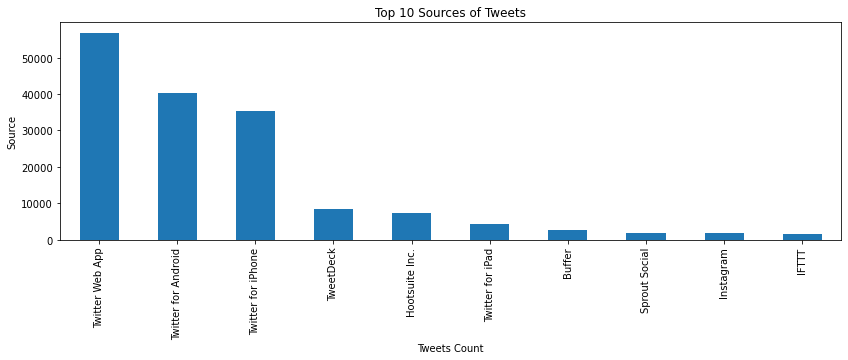

In [38]:
sources = tw['source'].value_counts()

fig = plt.subplots(figsize = (14,4))
plt.xlabel("Tweets Count")
plt.ylabel("Source")
sources[0:10].plot(kind='bar', title = "Top 10 Sources of Tweets", )

# 3. Top 10 Locations

Haha. The first location seems ot be astroworld, and since location seems to be specified by users, it will not likely to be a real location on Earth. Considering this and that 20% of the entries have no location values, using location for any useful insights seems like a long game.

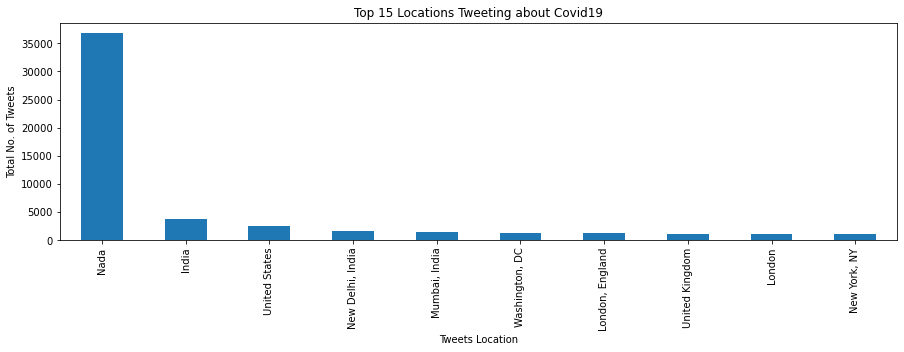

In [39]:
locs = tw['user_location'].value_counts()

fig = plt.subplots(figsize = (15,4))
plt.xlabel("Tweets Location")
plt.ylabel("Total No. of Tweets")
locs[0:10].plot(kind='bar', title = "Top 15 Locations Tweeting about Covid19", )

In [40]:
countries =tw['user_location'].str.split(',').str[-1]
countries

0                   astroworld
1                           NY
2                           KY
3         Stuck in the Middle 
4            Jammu and Kashmir
                  ...         
179103                 Nigeria
179104                 Ontario
179105               🇨🇦 Canada
179106           New York City
179107            South Africa
Name: user_location, Length: 179108, dtype: object

Now we might want to combine the States such as New York City, LA, all into a singular "USA" using an external dataset, but this has not been shown here because I wasn't sure if an external dataset should be used for this challenge

# 4. Source vs Location
<div id="4"></div>

## 4.1. India

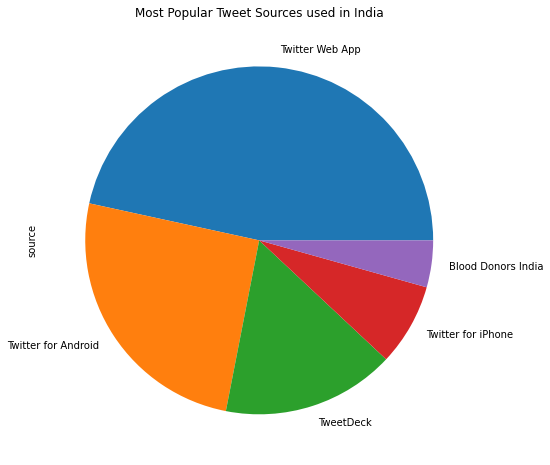

In [44]:
india_list=("India", "Mumbai, India", "New Delhi, India", "IN", "Bangalore, India", "Mumbai")

india_sources = tw['source'][tw['user_location'].isin(india_list)].value_counts().sort_values(ascending=False)
plt.figure(figsize=(15,8))
india_sources[0:5].plot(kind = 'pie', title = 'Most Popular Tweet Sources used in India')

Looks like most of the users in India are using the Web App followed by Android, and iPhone users are only 4th most popular!

My hypothesis is that the USA has the highest market for iPhones (there are more iPhones than Android phones there), so let's verify that!

## 4.2. USA

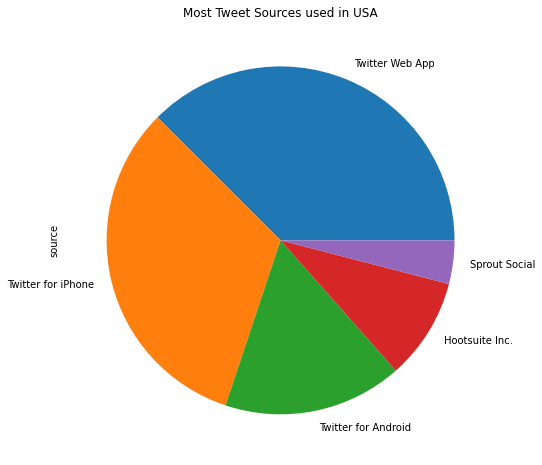

In [45]:
usa_list= ("USA", "US", "United States", "California", "New York, NY", "Los Angeles, CA", "Washington, DC")
usa_sources = tw['source'][tw['user_location'].isin(usa_list)].value_counts().sort_values(ascending=False)
plt.figure(figsize=(14,8))
usa_sources[0:5].plot(kind = 'pie', title = 'Most Tweet Sources used in USA')

iPhones are much more prevalent in the USA!

# 5. Dates 
<div id="5"></div>
Now let's look at the tweets posted by dates.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d0937b208>],
      dtype=object)

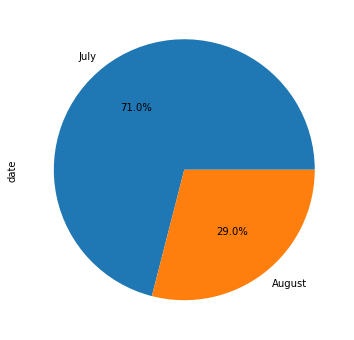

In [46]:
dates = tw['date'] # Last date till 29th August
dates = pd.DatetimeIndex(dates)
dates.month.value_counts().plot(kind="pie", subplots=True, figsize=(15, 6), 
                                labels = ['July', 'August'],  autopct='%1.1f%%')

# 6. Word Cloud
<div id="6"></div>

Text(0.5, 1.0, 'Most Used Words in Tweets')

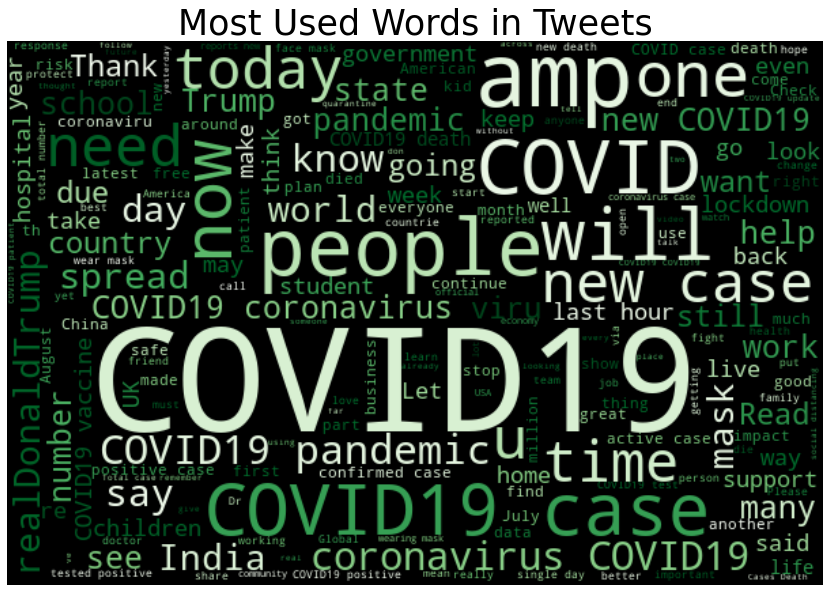

In [49]:
import re

def remove_tag(string):
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',string)
    return text

new_text=tw['text'].apply(lambda x:remove_tag(str(x)))

fig, (ax3) = plt.subplots(1,1,figsize=[17, 10])
wordcloud3 = WordCloud(background_color='black',colormap="Greens", 
                        width=600,height=400).generate(" ".join(new_text))

ax3.imshow(wordcloud3,interpolation='bilinear')
ax3.axis('off')
ax3.set_title('Most Used Words in Tweets',fontsize=35)

### Correlation:
Check for Null value exist in any of the columns:

,user_followers,user_friends,user_favourites,user_verified,is_retweet,emoji
user_followers,1.000000,-0.003580,-0.029218,0.320957,NaN,-0.026388
user_friends,-0.003580,1.000000,0.201050,0.012829,NaN,-0.007720
user_favourites,-0.029218,0.201050,1.000000,-0.061141,NaN,0.015796
user_verified,0.320957,0.012829,-0.061141,1.000000,NaN,0.009292
is_retweet,NaN,NaN,NaN,NaN,NaN,NaN
emoji,-0.026388,-0.007720,0.015796,0.009292,NaN,1.000000


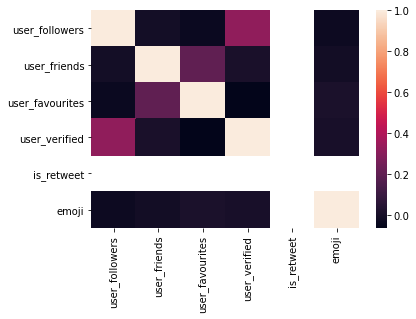

In [37]:
sns.heatmap(tw.corr())
tw.corr()

In [51]:
def duplicated_values_data(data):
    dup=[]
    columns=data.columns
    for i in data.columns:
        dup.append(sum(data[i].duplicated()))
    return pd.concat([pd.Series(columns),pd.Series(dup)],axis=1,keys=['Columns','Duplicate count'])

([<matplotlib.axis.XTick at 0x7f8d091c44a8>,
 [Text(0, 0, 'Unverified'), Text(0, 0, 'Verified')])

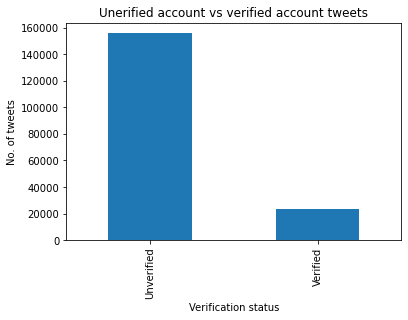

In [52]:
tw['user_verified'].value_counts().plot(kind='bar')
plt.xlabel("Verification status")
plt.ylabel("No. of tweets")
plt.title("Unerified account vs verified account tweets")
plt.xticks([False,True],['Unverified','Verified'])

In [53]:
tw['hashtags'].value_counts()

['Covid19']                                                               56168
['COVID19']                                                               37792
['covid19']                                                                3124
['coronavirus', 'CoronaVirusUpdate', 'COVID19', 'CoronavirusPandemic']      624
['coronavirus']                                                             550
                                                                          ...  
['embarrassing', 'Russia']                                                    1
['Marston', 'Lincolnshire', 'Covid19']                                        1
['tfl']                                                                       1
['Russia', 'COVID19', 'COVIDー19']                                             1
['COVID19', 'AMR']                                                            1
Name: hashtags, Length: 52640, dtype: int64

In [54]:
ds = tw['hashtags'].value_counts().reset_index()
ds.columns = ['hashtags', 'count']
ds = ds.sort_values(['count'])

# 7. Sentiment Analysis
<div id="7"></div>

Using a very primitive rule based sentiment analysis tool called Vader under NLTK. https://www.nltk.org/_modules/nltk/sentiment/vader.html

In [60]:
def char_is_emoji(character):
    return character in emoji.UNICODE_EMOJI
#does the text contain an emoji?
def text_has_emoji(text):
    for character in text:
        if character in emoji.UNICODE_EMOJI:
            return True
    return False
#remove the emoji
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

In [61]:
def nlp(tw):
    tw['token'] = tw['text'].apply(lambda x: x.lower())
    # get rid of '\n' from whitespace 
    tw['token'] = tw['token'].apply(lambda x: x.replace('\n', ' '))
    # regex remove hyperlinks
    tw['token'] = tw['token'].str.replace('http\S+|www.\S+|http', '', case=False)
    # removing '&gt;'
    tw['token'] = tw['token'].apply(lambda x: x.replace('&gt;', ''))
    # Checking if emoji in tokens column, use for EDA purposes otherwise not necessary to keep this column
    tw['emoji'] = tw['token'].apply(lambda x: text_has_emoji(x))
    # Removing Emojis from tokens
    tw['token'] = tw['token'].apply(lambda x: deEmojify(x))
    return tw


In [62]:
cleaned_tweets = (nlp(tw))
cleaned_tweets

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,token,emoji
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,['Covid19'],Twitter for iPhone,False,if i smelled the scent of hand sanitizers toda...,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,['Covid19'],Twitter for Android,False,hey @yankees @yankeespr and @mlb - wouldn't it...,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False,@diane3443 @wdunlap @realdonaldtrump trump nev...,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False,@brookbanktv the one gift #covid19 has give me...,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False,25 july : media bulletin on novel #coronavirus...,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179103,AJIMATI AbdulRahman O.,"Ilorin, Nigeria",Animal Scientist|| Muslim|| Real Madrid/Chelsea,2013-12-30 18:59:19,412,1609,1062,False,2020-08-29 19:44:21,Thanks @IamOhmai for nominating me for the @WH...,['WearAMask'],Twitter for Android,False,thanks @iamohmai for nominating me for the @wh...,False
179104,Jason,Ontario,When your cat has more baking soda than Ninja ...,2011-12-21 04:41:30,150,182,7295,False,2020-08-29 19:44:16,2020! The year of insanity! Lol! #COVID19 http...,['COVID19'],Twitter for Android,False,2020! the year of insanity! lol! #covid19,False
179105,BEEHEMOTH ⏳,🇨🇦 Canada,⚒️ The Architects of Free Trade ⚒️ Really Did ...,2016-07-13 17:21:59,1623,2160,98000,False,2020-08-29 19:44:15,@CTVNews A powerful painting by Juan Lucena. I...,['Covid19'],Twitter Web App,False,@ctvnews a powerful painting by juan lucena. i...,False
179106,Gary DelPonte,New York City,"Global UX UI Visual Designer. StoryTeller, Mus...",2009-10-27 17:43:13,1338,1111,0,False,2020-08-29 19:44:14,"More than 1,200 students test positive for #CO...",['COVID19'],Twitter for iPhone,False,"more than 1,200 students test positive for #co...",False


In [63]:
def categoriser(diction):
    if(diction['neg']>0):
        return("Negative")
    elif(diction['pos']>0):
        return('Positive')
    else:
        return('Neutral')
    
def SentiAnlyser(df):
    analyser= SentimentIntensityAnalyzer()
    df['sentiment']=df['token'].apply(lambda x: analyser.polarity_scores(x))
    df['sentiment']=df['sentiment'].apply(lambda x:categoriser(x))
    return df


tweets2=SentiAnlyser(cleaned_tweets)

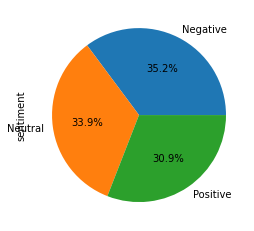

In [64]:
tweets2['sentiment'].value_counts().plot(kind="pie", autopct='%1.1f%%')

In [39]:
tw['textLength'] = tw['text'].str.len()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,token,emoji,sentiment,textLength
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,['Covid19'],Twitter for iPhone,False,if i smelled the scent of hand sanitizers toda...,False,Positive,140
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,['Covid19'],Twitter for Android,False,hey @yankees @yankeespr and @mlb - wouldn't it...,False,Negative,140
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False,@diane3443 @wdunlap @realdonaldtrump trump nev...,False,Negative,140
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False,@brookbanktv the one gift #covid19 has give me...,False,Positive,139
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False,25 july : media bulletin on novel #coronavirus...,False,Positive,138


# Future Score 

1. Comparing Negative or Positive tweets or more followers
2. Text generation using Markov Chains
3. Verifying [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law)